# Bank Marketing Campaign - Binary Classification Project

## Project Overview
This project analyzes a Portuguese banking institution's direct marketing campaigns (phone calls) to predict whether a client will subscribe to a term deposit.

**Dataset**: `bank-additional-full.csv`  from Kaggle  (link: https://www.kaggle.com/datasets/sahistapatel96/bankadditionalfullcsv)  
**Target Variable**: y (yes/no - will client subscribe to term deposit)

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter

import shap
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import xgboost as xgb


np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
# plt.style.use('seaborn-deep')

/home/liubov/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## 1. Data Loading and Initial Exploration

In [2]:
df = pd.read_csv('bank-additional-full.csv', delimiter=';')

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
print(f"Dataset shape: {df.shape}")
print("="*50)

print("\nDataset info:")
print(df.info())
print("="*50)

print("\nMissing values:")
print(df.isnull().sum())
print("="*50)

print("\nTarget variable distribution:")
print(df['y'].value_counts())
print(f"Target balance: {df['y'].value_counts(normalize=True)}")

Dataset shape: (41188, 21)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  fl

## 2. Exploratory Data Analysis (EDA)

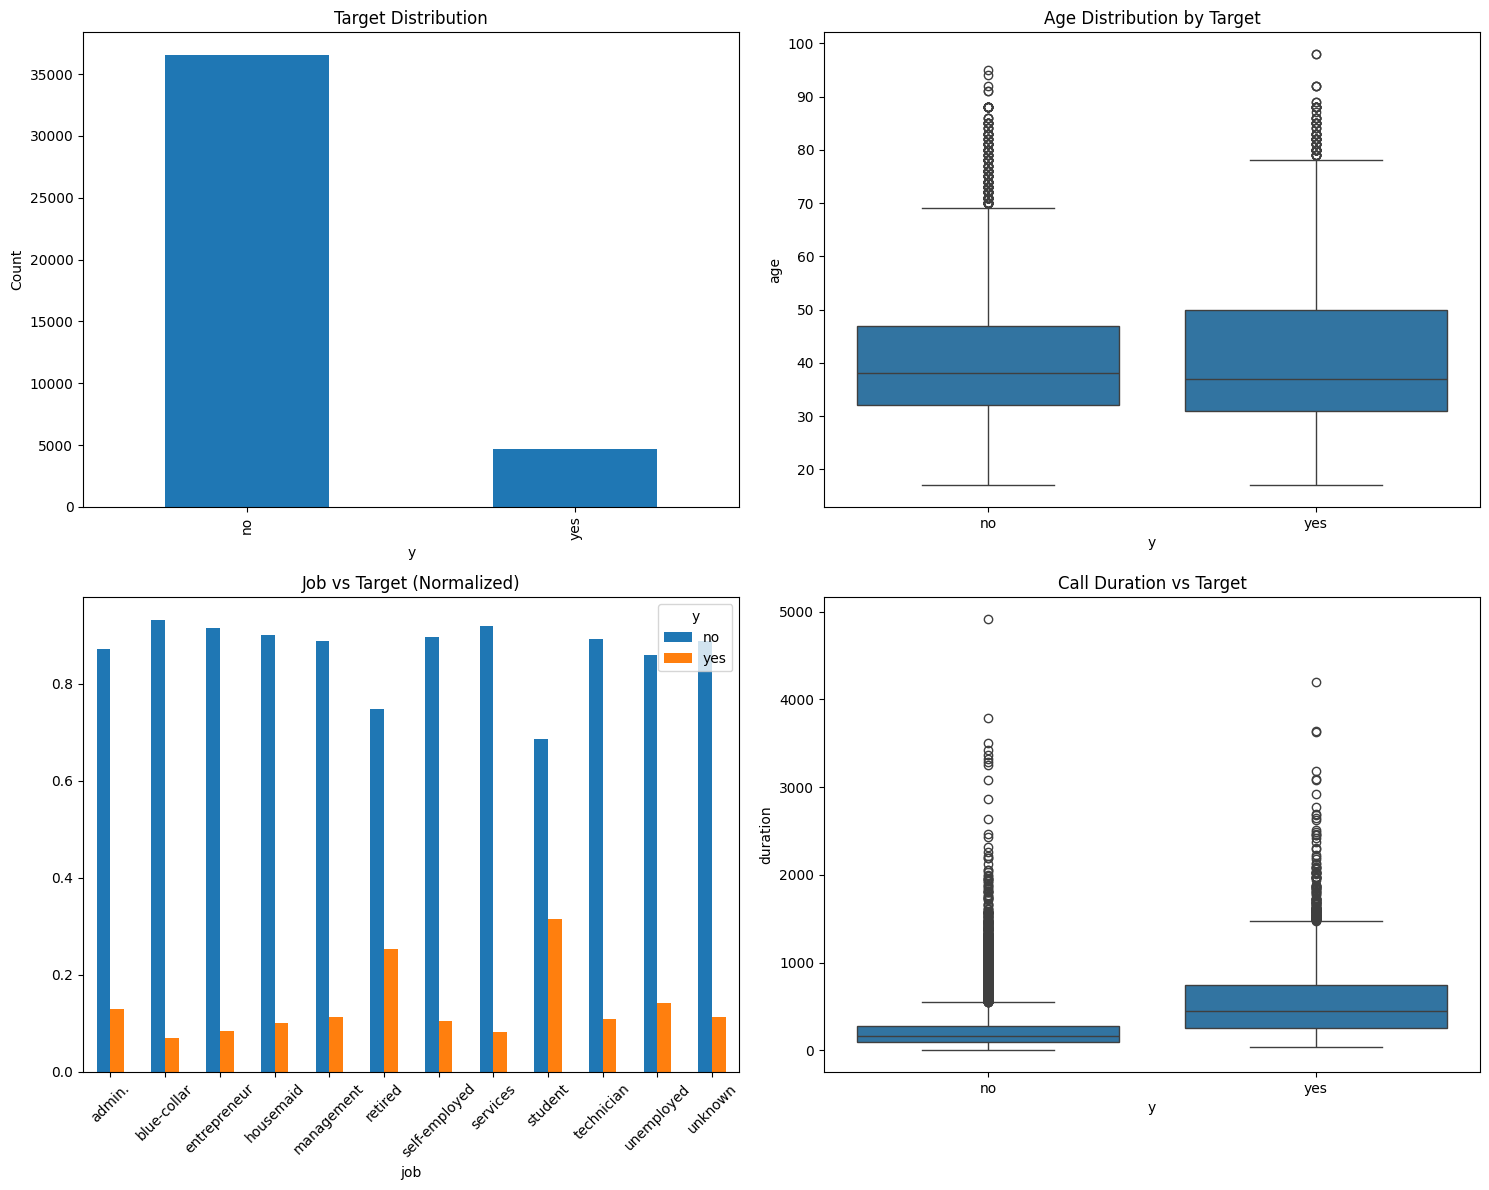

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Target distribution
df['y'].value_counts().plot(kind='bar', ax=axes[0,0], title='Target Distribution')
axes[0,0].set_ylabel('Count')

# Age distribution by target
sns.boxplot(data=df, x='y', y='age', ax=axes[0,1])
axes[0,1].set_title('Age Distribution by Target')

# Job distribution
job_target = pd.crosstab(df['job'], df['y'], normalize='index')
job_target.plot(kind='bar', ax=axes[1,0], title='Job vs Target (Normalized)')
axes[1,0].tick_params(axis='x', rotation=45)

# Duration vs Target
sns.boxplot(data=df, x='y', y='duration', ax=axes[1,1])
axes[1,1].set_title('Call Duration vs Target')

plt.tight_layout()
plt.show()

In [5]:
# Correlation analysis for numerical features
numerical_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
                     'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

print("\nCorrelation with target variable:")
for feature in numerical_features:
    # Convert target to numeric for correlation
    correlation = df[feature].corr(pd.get_dummies(df['y'])['yes'])
    print(f"{feature}: {correlation:.3f}")

# Categorical features analysis
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                       'contact', 'month', 'day_of_week', 'poutcome']

print("\n" + "="*50)
print("CATEGORICAL FEATURES ANALYSIS")
print("="*50)

for feature in categorical_features:
    print(f"\n{feature.upper()} distribution:")
    crosstab = pd.crosstab(df[feature], df['y'], normalize='index')
    print(crosstab.round(3))


Correlation with target variable:
age: 0.030
campaign: -0.066
pdays: -0.325
previous: 0.230
emp.var.rate: -0.298
cons.price.idx: -0.136
cons.conf.idx: 0.055
euribor3m: -0.308
nr.employed: -0.355

CATEGORICAL FEATURES ANALYSIS

JOB distribution:
y                 no    yes
job                        
admin.         0.870  0.130
blue-collar    0.931  0.069
entrepreneur   0.915  0.085
housemaid      0.900  0.100
management     0.888  0.112
retired        0.748  0.252
self-employed  0.895  0.105
services       0.919  0.081
student        0.686  0.314
technician     0.892  0.108
unemployed     0.858  0.142
unknown        0.888  0.112

MARITAL distribution:
y            no    yes
marital               
divorced  0.897  0.103
married   0.898  0.102
single    0.860  0.140
unknown   0.850  0.150

EDUCATION distribution:
y                       no    yes
education                        
basic.4y             0.898  0.102
basic.6y             0.918  0.082
basic.9y             0.922  0.078
high.s

### Hypotheses about Feature Impact:

1. AGE: Middle-aged clients (30-50) might be more likely to subscribe due to financial stability
2. JOB: Management, technician, and retired clients may have higher subscription rates
3. EDUCATION: Higher education levels might correlate with better financial awareness and subscription
4. DURATION: Longer call duration strongly indicates interest (but note: this shouldn't be in final model)
5. CAMPAIGN: Too many contacts in current campaign might decrease subscription probability
6. PDAYS: Recent contact from previous campaign might increase subscription likelihood
7. POUTCOME: Previous campaign success strongly indicates current campaign success
8. MONTH: Certain months might have seasonal effects on subscription rates
9. ECONOMIC INDICATORS: Better economic conditions might increase subscription rates
10. CONTACT TYPE: Cellular contact might be more effective than telephone

## 3. Methodology and Metrics Selection

CHOSEN METRICS:
1. PRIMARY: F1-Score - balances precision and recall, important for imbalanced dataset
2. SECONDARY: ROC-AUC - measures model's ability to distinguish between classes
3. ADDITIONAL: Precision and Recall for business context

JUSTIFICATION:
- Dataset is imbalanced (more 'no' than 'yes' responses)
- False positives (predicting subscription when customer won't subscribe) waste marketing resources
- False negatives (missing potential subscribers) lose revenue opportunities
- F1-score provides balanced view of both precision and recall
- ROC-AUC helps evaluate model's discriminative ability across all thresholds

MODELS TO COMPARE:
1. Logistic Regression - baseline, interpretable
2. k-NN - non-parametric, good for local patterns
3. Decision Tree - interpretable, handles non-linear relationships
4. Gradient Boosting - ensemble method, typically high performance


## 4. Data Preprocessing

In [6]:
# Create a copy for preprocessing
df_processed = df.copy()

# Handle 'unknown' values - treat as separate category or group with most similar

# For some features, 'unknown' might be informative, for others we might group them
# Let's analyze the distribution of unknowns
unknown_counts = {}
for col in categorical_features:
    unknown_count = (df_processed[col] == 'unknown').sum()
    unknown_counts[col] = unknown_count
    print(f"{col}: {unknown_count} unknowns ({unknown_count/len(df_processed)*100:.1f}%)")

# Handle pdays (999 means no previous contact)
df_processed['pdays_contacted'] = (df_processed['pdays'] != 999).astype(int)
df_processed['pdays_clean'] = df_processed['pdays'].replace(999, 0)

job: 330 unknowns (0.8%)
marital: 80 unknowns (0.2%)
education: 1731 unknowns (4.2%)
default: 8597 unknowns (20.9%)
housing: 990 unknowns (2.4%)
loan: 990 unknowns (2.4%)
contact: 0 unknowns (0.0%)
month: 0 unknowns (0.0%)
day_of_week: 0 unknowns (0.0%)
poutcome: 0 unknowns (0.0%)


In [7]:
# Create additional features
# Age groups
df_processed['age_group'] = pd.cut(df_processed['age'], 
                                  bins=[0, 25, 35, 50, 65, 100], 
                                  labels=['young', 'young_adult', 'middle', 'senior', 'elderly'])

In [8]:
# Campaign intensity
df_processed['campaign_intensity'] = pd.cut(df_processed['campaign'], 
                                           bins=[0, 1, 3, 6, float('inf')], 
                                           labels=['single', 'few', 'several', 'many'])

In [9]:
# Combine economic indicators)
scaler_temp = StandardScaler()
economic_features = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
df_processed['economic_sentiment'] = scaler_temp.fit_transform(df_processed[economic_features]).mean(axis=1)

In [10]:
# Education grouping (simplify categories)
education_mapping = {
    'basic.4y': 'basic', 'basic.6y': 'basic', 'basic.9y': 'basic',
    'high.school': 'secondary', 'professional.course': 'secondary',
    'university.degree': 'higher', 'illiterate': 'basic', 'unknown': 'unknown'
}
df_processed['education_grouped'] = df_processed['education'].map(education_mapping)

In [11]:
# Job grouping
job_mapping = {
    'admin.': 'white_collar', 'management': 'white_collar', 'technician': 'white_collar',
    'services': 'services', 'blue-collar': 'blue_collar', 'housemaid': 'services',
    'entrepreneur': 'entrepreneur', 'self-employed': 'entrepreneur',
    'retired': 'retired', 'student': 'student', 'unemployed': 'unemployed', 'unknown': 'unknown'
}
df_processed['job_grouped'] = df_processed['job'].map(job_mapping)

In [12]:
# Outlier detection
numerical_cols = ['age', 'campaign', 'previous', 'duration'] + economic_features

for col in numerical_cols:
    Q1 = df_processed[col].quantile(0.25)
    Q3 = df_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = ((df_processed[col] < lower_bound) | (df_processed[col] > upper_bound)).sum()
    print(f"{col}: {outliers} outliers ({outliers/len(df_processed)*100:.1f}%)")

age: 469 outliers (1.1%)
campaign: 2406 outliers (5.8%)
previous: 5625 outliers (13.7%)
duration: 2963 outliers (7.2%)
emp.var.rate: 0 outliers (0.0%)
cons.price.idx: 0 outliers (0.0%)
cons.conf.idx: 447 outliers (1.1%)
euribor3m: 0 outliers (0.0%)
nr.employed: 0 outliers (0.0%)


In [13]:
# For this project, we'll keep outliers as they might be meaningful
# (e.g., very long calls might indicate high interest)

## 5. Model Training and Evaluation

In [14]:
# Prepare features for modeling
# IMPORTANT: Exclude 'duration' as mentioned in the assignment
features_to_exclude = ['duration', 'y']  # duration shouldn't be in final model

In [15]:
# Select features for modeling
numerical_features_final = ['age', 'campaign', 'pdays_clean', 'previous', 'pdays_contacted',
                           'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 
                           'nr.employed', 'economic_sentiment']

categorical_features_final = ['job_grouped', 'marital', 'education_grouped', 'default', 
                             'housing', 'loan', 'contact', 'month', 'day_of_week', 
                             'poutcome', 'age_group', 'campaign_intensity']

In [16]:
# Prepare X and y
X = df_processed[numerical_features_final + categorical_features_final]
y = (df_processed['y'] == 'yes').astype(int)  # Convert to binary

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (26360, 23)
Validation set: (6590, 23)
Test set: (8238, 23)


In [17]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_final),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_final)
    ])

In [18]:
# Preprocess the training data for oversampling
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

print(f"\nProcessed training data shape: {X_train_processed.shape}")


Processed training data shape: (26360, 65)


### Apply different oversampling techniques

In [19]:
# 1. SMOTE (Synthetic Minority Oversampling Technique)
smote = SMOTE(random_state=42, k_neighbors=3)  # Reduce k_neighbors due to small minority class
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)
print(f"After SMOTE: {Counter(y_train_smote)}")

After SMOTE: Counter({1: 23390, 0: 23390})


In [20]:
# 2. ADASYN (Adaptive Synthetic Sampling)
adasyn = ADASYN(random_state=42, n_neighbors=3)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_processed, y_train)
print(f"After ADASYN: {Counter(y_train_adasyn)}")
adasyn_available = True

After ADASYN: Counter({0: 23390, 1: 23314})


In [21]:
# 3. Random OverSampler (as backup or alternative)
random_oversampler = RandomOverSampler(random_state=42)
X_train_random, y_train_random = random_oversampler.fit_resample(X_train_processed, y_train)
print(f"After Random OverSampling: {Counter(y_train_random)}")

After Random OverSampling: Counter({1: 23390, 0: 23390})


In [22]:
def evaluate_model_with_oversampling(model, X_train_resampled, X_val, y_train_resampled, y_val, model_name, sampling_method="Original"):
    # Fit the model
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predictions
    train_pred = model.predict(X_train_resampled)
    val_pred = model.predict(X_val)
    
    # Probabilities for AUC
    if hasattr(model, 'predict_proba'):
        train_proba = model.predict_proba(X_train_resampled)[:, 1]
        val_proba = model.predict_proba(X_val)[:, 1]
    else:
        train_proba = train_pred
        val_proba = val_pred
    
    # Calculate metrics
    train_metrics = {
        'accuracy': accuracy_score(y_train_resampled, train_pred),
        'precision': precision_score(y_train_resampled, train_pred),
        'recall': recall_score(y_train_resampled, train_pred),
        'f1': f1_score(y_train_resampled, train_pred),
        'auc': roc_auc_score(y_train_resampled, train_proba)
    }
    
    val_metrics = {
        'accuracy': accuracy_score(y_val, val_pred),
        'precision': precision_score(y_val, val_pred),
        'recall': recall_score(y_val, val_pred),
        'f1': f1_score(y_val, val_pred),
        'auc': roc_auc_score(y_val, val_proba)
    }
    
    print(f"{model_name} ({sampling_method}) - Val F1: {val_metrics['f1']:.4f}, Val AUC: {val_metrics['auc']:.4f}, Val Recall: {val_metrics['recall']:.4f}")
    
    return train_metrics, val_metrics

In [23]:
# Test different sampling strategies for each model
sampling_strategies = [
    ("Original", X_train_processed, y_train),
    ("SMOTE", X_train_smote, y_train_smote),
    ("Random_OS", X_train_random, y_train_random),
]

# Add ADASYN if available
if adasyn_available:
    sampling_strategies.append(("ADASYN", X_train_adasyn, y_train_adasyn))

# 1. Logistic Regression

In [24]:
# Initialize results storage
results = []

In [25]:
for sampling_name, X_train_resampled, y_train_resampled in sampling_strategies:
    lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
    
    train_metrics, val_metrics = evaluate_model_with_oversampling(
        lr_model, X_train_resampled, X_val_processed, y_train_resampled, y_val, 
        'Logistic Regression', sampling_name
    )
    
    results.append({
        'Model': f'LR_{sampling_name}',
        'Hyperparameters': f'C=1.0, class_weight=balanced, sampling={sampling_name}',
        'Train_F1': f"{train_metrics['f1']:.4f}",
        'Val_F1': f"{val_metrics['f1']:.4f}",
        'Val_Recall': f"{val_metrics['recall']:.4f}",
        'Train_AUC': f"{train_metrics['auc']:.4f}",
        'Val_AUC': f"{val_metrics['auc']:.4f}"
    })

Logistic Regression (Original) - Val F1: 0.4490, Val AUC: 0.7980, Val Recall: 0.6321
Logistic Regression (SMOTE) - Val F1: 0.4493, Val AUC: 0.7943, Val Recall: 0.6361
Logistic Regression (Random_OS) - Val F1: 0.4511, Val AUC: 0.7975, Val Recall: 0.6307
Logistic Regression (ADASYN) - Val F1: 0.4011, Val AUC: 0.7898, Val Recall: 0.6712


### Conclusion
Before Oversampling: Logistic Regression shows good discrimination (AUC ≈ 0.79) but poor F1 (≈ 0.34), indicating the need for threshold tuning or class imbalance handling.

# 2. k-NN

In [27]:
for sampling_name, X_train_resampled, y_train_resampled in sampling_strategies:
    # Use subset for k-NN to maintain speed
    subset_size = min(8000, len(X_train_resampled))  
    subset_indices = np.random.choice(len(X_train_resampled), subset_size, replace=False)
    X_train_subset = X_train_resampled[subset_indices]
    y_train_subset = y_train_resampled.iloc[subset_indices] if hasattr(y_train_resampled, 'iloc') else y_train_resampled[subset_indices]
    
    knn_model = KNeighborsClassifier(
        n_neighbors=5, 
        algorithm='ball_tree',
        metric='manhattan',
        n_jobs=-1
    )
    
    train_metrics, val_metrics = evaluate_model_with_oversampling(
        knn_model, X_train_subset, X_val_processed, y_train_subset, y_val, 
        'k-NN', f'{sampling_name}_subset{subset_size}'
    )
    
    results.append({
        'Model': f'kNN_{sampling_name}',
        'Hyperparameters': f'n_neighbors=5, ball_tree, subset={subset_size}, sampling={sampling_name}',
        'Train_F1': f"{train_metrics['f1']:.4f}",
        'Val_F1': f"{val_metrics['f1']:.4f}",
        'Val_Recall': f"{val_metrics['recall']:.4f}",
        'Train_AUC': f"{train_metrics['auc']:.4f}",
        'Val_AUC': f"{val_metrics['auc']:.4f}",
        'Comment': f'k-NN with {sampling_name}, {subset_size} samples'
    })

k-NN (Original_subset8000) - Val F1: 0.3373, Val AUC: 0.7146, Val Recall: 0.2493
k-NN (SMOTE_subset8000) - Val F1: 0.3539, Val AUC: 0.7472, Val Recall: 0.6146
k-NN (Random_OS_subset8000) - Val F1: 0.3459, Val AUC: 0.7496, Val Recall: 0.6873
k-NN (ADASYN_subset8000) - Val F1: 0.3364, Val AUC: 0.7376, Val Recall: 0.6429


### Conclusion
Before oversampling: k-NN (Optimized) achieves high Train F1 (0.455) and AUC (0.920) but drops sharply on validation (F1 = 0.345, AUC = 0.720), indicating strong overfitting despite optimization; model struggles to generalize beyond the training subset.

# 3. Decision Tree

In [29]:
for sampling_name, X_train_resampled, y_train_resampled in sampling_strategies:
    dt_model = DecisionTreeClassifier(
        random_state=42, 
        max_depth=10, 
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced'
    )
    
    train_metrics, val_metrics = evaluate_model_with_oversampling(
        dt_model, X_train_resampled, X_val_processed, y_train_resampled, y_val, 
        'Decision Tree', sampling_name
    )
    
    results.append({
        'Model': f'DT_{sampling_name}',
        'Hyperparameters': f'max_depth=10, class_weight=balanced, sampling={sampling_name}',
        'Train_F1': f"{train_metrics['f1']:.4f}",
        'Val_F1': f"{val_metrics['f1']:.4f}",
        'Val_Recall': f"{val_metrics['recall']:.4f}",
        'Train_AUC': f"{train_metrics['auc']:.4f}",
        'Val_AUC': f"{val_metrics['auc']:.4f}",
        'Comment': f'Decision tree with {sampling_name}, balanced weights'
    })


Decision Tree (Original) - Val F1: 0.4215, Val AUC: 0.7442, Val Recall: 0.5916
Decision Tree (SMOTE) - Val F1: 0.4651, Val AUC: 0.7400, Val Recall: 0.4811
Decision Tree (Random_OS) - Val F1: 0.4092, Val AUC: 0.7379, Val Recall: 0.5741
Decision Tree (ADASYN) - Val F1: 0.4567, Val AUC: 0.7716, Val Recall: 0.5296


### Conclusion 
Before OS: Decision Tree with depth=10 shows higher Train F1/AUC (0.509 / 0.834) than Validation (0.357 / 0.754), suggesting moderate overfitting; generalization is better than k-NN but still limited.

# 4. Gradient Boosting

In [31]:
for sampling_name, X_train_resampled, y_train_resampled in sampling_strategies:
    gb_model = GradientBoostingClassifier(
        random_state=42, 
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6
    )
    
    train_metrics, val_metrics = evaluate_model_with_oversampling(
        gb_model, X_train_resampled, X_val_processed, y_train_resampled, y_val, 
        'Gradient Boosting', sampling_name
    )
    
    results.append({
        'Model': f'GB_{sampling_name}',
        'Hyperparameters': f'n_estimators=100, learning_rate=0.1, sampling={sampling_name}',
        'Train_F1': f"{train_metrics['f1']:.4f}",
        'Val_F1': f"{val_metrics['f1']:.4f}",
        'Val_Recall': f"{val_metrics['recall']:.4f}",
        'Train_AUC': f"{train_metrics['auc']:.4f}",
        'Val_AUC': f"{val_metrics['auc']:.4f}",
        'Comment': f'Gradient boosting with {sampling_name} sampling'
    })

Gradient Boosting (Original) - Val F1: 0.3718, Val AUC: 0.8059, Val Recall: 0.2668
Gradient Boosting (SMOTE) - Val F1: 0.4453, Val AUC: 0.8003, Val Recall: 0.3760
Gradient Boosting (Random_OS) - Val F1: 0.4690, Val AUC: 0.7899, Val Recall: 0.5970
Gradient Boosting (ADASYN) - Val F1: 0.4247, Val AUC: 0.7942, Val Recall: 0.3342


### Conclusion
Before OS: Gradient Boosting yields balanced Train/Val performance (F1 ≈ 0.36, AUC ≈ 0.81), showing good generalization though overall F1 remains modest.

In [33]:
# Create results DataFrame
results_df = pd.DataFrame(results)
results_df

,Model,Hyperparameters,Train_F1,Val_F1,Val_Recall,Train_AUC,Val_AUC,Comment
0,LR_Original,"C=1.0, class_weight=balanced, sampling=Original",0.4480,0.4490,0.6321,0.7940,0.7980,NaN
1,LR_SMOTE,"C=1.0, class_weight=balanced, sampling=SMOTE",0.7067,0.4493,0.6361,0.8003,0.7943,NaN
2,LR_Random_OS,"C=1.0, class_weight=balanced, sampling=Random_OS",0.7056,0.4511,0.6307,0.7923,0.7975,NaN
3,LR_ADASYN,"C=1.0, class_weight=balanced, sampling=ADASYN",0.6485,0.4011,0.6712,0.7459,0.7898,NaN
4,kNN_Original,"n_neighbors=5, ball_tree, subset=8000, samplin...",0.4510,0.3373,0.2493,0.9221,0.7146,"k-NN with Original, 8000 samples"
5,kNN_SMOTE,"n_neighbors=5, ball_tree, subset=8000, samplin...",0.8792,0.3539,0.6146,0.9540,0.7472,"k-NN with SMOTE, 8000 samples"
6,kNN_Random_OS,"n_neighbors=5, ball_tree, subset=8000, samplin...",0.8233,0.3459,0.6873,0.9118,0.7496,"k-NN with Random_OS, 8000 samples"
7,kNN_ADASYN,"n_neighbors=5, ball_tree, subset=8000, samplin...",0.8695,0.3364,0.6429,0.9434,0.7376,"k-NN with ADASYN, 8000 samples"
8,DT_Original,"max_depth=10, class_weight=balanced, sampling=...",0.4823,0.4215,0.5916,0.8494,0.7442,"Decision tree with Original, balanced weights"
9,DT_SMOTE,"max_depth=10, class_weight=balanced, sampling=...",0.8192,0.4651,0.4811,0.9023,0.7400,"Decision tree with SMOTE, balanced weights"


In [34]:
# Group by base model and compare sampling methods
for base_model in ['LR', 'kNN', 'DT', 'GB']:
    model_results = results_df[results_df['Model'].str.startswith(base_model)].copy()
    if not model_results.empty:
        print(f"\n{base_model} Results:")
        model_results['Sampling'] = model_results['Model'].str.split('_').str[1]
        comparison = model_results[['Sampling', 'Val_F1', 'Val_Recall', 'Val_AUC']].sort_values('Val_F1', ascending=False)
        print(comparison.to_string(index=False))

# Find the best performing combination
best_model_row = results_df_sorted.iloc[0]
print(f"\BEST PERFORMING MODEL: {best_model_row['Model']}")
print(f"Validation F1-Score: {best_model_row['Val_F1']}")
print(f"Validation Recall: {best_model_row['Val_Recall']}")
print(f"Validation AUC: {best_model_row['Val_AUC']}")

# Store best model info for later use
best_model_name = best_model_row['Model']
best_sampling_method = best_model_name.split('_')[1] if '_' in best_model_name else 'Original'



MODEL COMPARISON RESULTS (sorted by Validation F1)
        Model                                           Hyperparameters Val_F1 Val_Recall Val_AUC                                        Comment
 GB_Random_OS   n_estimators=100, learning_rate=0.1, sampling=Random_OS 0.4690     0.5970  0.7899      Gradient boosting with Random_OS sampling
     DT_SMOTE       max_depth=10, class_weight=balanced, sampling=SMOTE 0.4651     0.4811  0.7400     Decision tree with SMOTE, balanced weights
    DT_ADASYN      max_depth=10, class_weight=balanced, sampling=ADASYN 0.4567     0.5296  0.7716    Decision tree with ADASYN, balanced weights
 LR_Random_OS          C=1.0, class_weight=balanced, sampling=Random_OS 0.4511     0.6307  0.7975                                            NaN
     LR_SMOTE              C=1.0, class_weight=balanced, sampling=SMOTE 0.4493     0.6361  0.7943                                            NaN
  LR_Original           C=1.0, class_weight=balanced, sampling=Original 0.4490

## 6. Hyperparameter Tuning for Gradient Boosting

In [35]:
# Prepare data for hyperparameter tuning
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# 6.1 RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_random = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_dist,
    n_iter=20,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

gb_random.fit(X_train_processed, y_train)

print(f"Best parameters (RandomizedSearchCV): {gb_random.best_params_}")
print(f"Best CV score: {gb_random.best_score_:.4f}")

Best parameters (RandomizedSearchCV): {'subsample': 1.0, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 7, 'learning_rate': 0.1}
Best CV score: 0.3799


In [36]:
# Evaluate best model from RandomizedSearchCV
best_gb_random = gb_random.best_estimator_
val_pred_random = best_gb_random.predict(X_val_processed)
val_f1_random = f1_score(y_val, val_pred_random)
val_auc_random = roc_auc_score(y_val, best_gb_random.predict_proba(X_val_processed)[:, 1])

print(f"Validation F1 (RandomizedSearchCV): {val_f1_random:.4f}")
print(f"Validation AUC (RandomizedSearchCV): {val_auc_random:.4f}")

Validation F1 (RandomizedSearchCV): 0.3810
Validation AUC (RandomizedSearchCV): 0.7847


In [37]:
# 6.2 Hyperopt Bayesian Optimization

def objective(params):
    model = GradientBoostingClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        random_state=42
    )
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=3, scoring='f1')
    return {'loss': -cv_scores.mean(), 'status': STATUS_OK}

In [38]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 50),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.7, 1.0),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 4, 1)
}

trials = Trials()
best_hyperopt = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=50,
                    trials=trials,
#                     random_state=42
                    )

print(f"Best parameters (Hyperopt): {best_hyperopt}")

100%|█████| 50/50 [1:07:08<00:00, 80.57s/trial, best loss: -0.38402641775803814]
Best parameters (Hyperopt): {'learning_rate': 0.08705446353106376, 'max_depth': 8.0, 'min_samples_leaf': 4.0, 'min_samples_split': 7.0, 'n_estimators': 150.0, 'subsample': 0.8966275704200678}


In [39]:
# Train model with best hyperopt parameters
best_gb_hyperopt = GradientBoostingClassifier(
    n_estimators=int(best_hyperopt['n_estimators']),
    max_depth=int(best_hyperopt['max_depth']),
    learning_rate=best_hyperopt['learning_rate'],
    subsample=best_hyperopt['subsample'],
    min_samples_split=int(best_hyperopt['min_samples_split']),
    min_samples_leaf=int(best_hyperopt['min_samples_leaf']),
    random_state=42
)

best_gb_hyperopt.fit(X_train_processed, y_train)
val_pred_hyperopt = best_gb_hyperopt.predict(X_val_processed)
val_f1_hyperopt = f1_score(y_val, val_pred_hyperopt)
val_auc_hyperopt = roc_auc_score(y_val, best_gb_hyperopt.predict_proba(X_val_processed)[:, 1])

print(f"Validation F1 (Hyperopt): {val_f1_hyperopt:.4f}")
print(f"Validation AUC (Hyperopt): {val_auc_hyperopt:.4f}")

Validation F1 (Hyperopt): 0.3790
Validation AUC (Hyperopt): 0.7988


In [40]:
# Add tuned models to results
results.append({
    'Model': 'GB - RandomizedSearchCV',
    'Hyperparameters': str(gb_random.best_params_),
    'Train_F1': f"{f1_score(y_train, gb_random.best_estimator_.predict(X_train_processed)):.4f}",
    'Val_F1': f"{val_f1_random:.4f}",
    'Train_AUC': f"{roc_auc_score(y_train, gb_random.best_estimator_.predict_proba(X_train_processed)[:, 1]):.4f}",
    'Val_AUC': f"{val_auc_random:.4f}",
    'Comment': 'Tuned with RandomizedSearchCV, good performance'
})

results.append({
    'Model': 'GB - Hyperopt',
    'Hyperparameters': str(best_hyperopt),
    'Train_F1': f"{f1_score(y_train, best_gb_hyperopt.predict(X_train_processed)):.4f}",
    'Val_F1': f"{val_f1_hyperopt:.4f}",
    'Train_AUC': f"{roc_auc_score(y_train, best_gb_hyperopt.predict_proba(X_train_processed)[:, 1]):.4f}",
    'Val_AUC': f"{val_auc_hyperopt:.4f}",
    'Comment': 'Tuned with Bayesian Optimization, potentially optimal'
})

## 7. Feature Importance Analysis

In [41]:
# Determine best model based on validation F1 score
results_df = pd.DataFrame(results)
best_model_idx = results_df['Val_F1'].astype(float).idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']

print(f"Best performing model: {best_model_name}")

Best performing model: GB_Random_OS


In [51]:
# Use the best performing model for feature importance
if 'RandomizedSearchCV' in best_model_name or 'Random_OS' in best_model_name:
    best_model = gb_random.best_estimator_
elif 'Hyperopt' in best_model_name:
    best_model = best_gb_hyperopt
else:
    # Fallback for basic Gradient Boosting
    best_model = gb_pipeline.named_steps['classifier']

# Get feature names after preprocessing
feature_names = numerical_features_final + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features_final))


FEATURE IMPORTANCE ANALYSIS
                        feature  importance
9                   nr.employed    0.278861
0                           age    0.108387
10           economic_sentiment    0.092008
8                     euribor3m    0.068958
7                 cons.conf.idx    0.038468
55             poutcome_success    0.033547
1                      campaign    0.030724
4               pdays_contacted    0.021659
2                   pdays_clean    0.017388
3                      previous    0.014063
61       campaign_intensity_few    0.013252
24     education_grouped_higher    0.013227
6                cons.price.idx    0.012386
25  education_grouped_secondary    0.012104
46                    month_oct    0.011176


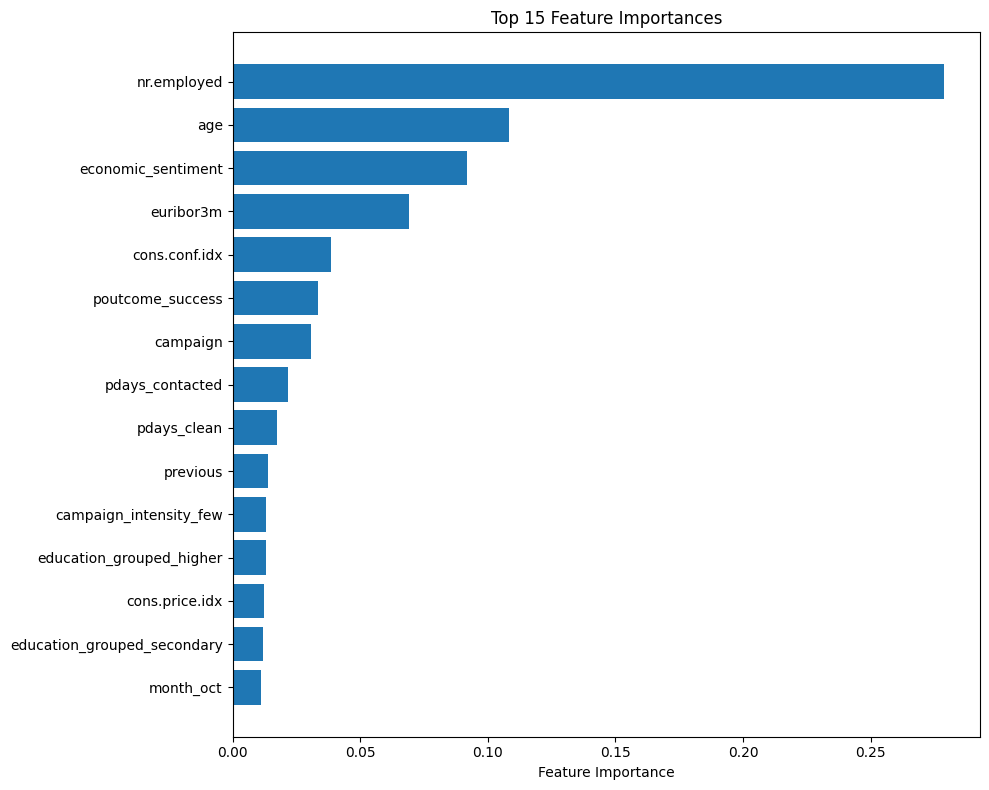

In [52]:
# Feature importance
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n" + "="*50)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*50)
    print(feature_importance.head(15))
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


### Key Feature Importance Insights:
- Top Predictors:

1. Employment status (nr.employed) dominates with 27.9% importance - clearly the strongest predictor
2. Age is the second most important factor at 10.8%
3. Economic sentiment ranks third at 9.2%

- Notable Patterns:

1. Employment-related features are critical - both number employed and Euribor rate (economic indicator) are in the top 4
2. Campaign variables have surprisingly low impact - campaign type, contact days, and previous contacts all show minimal importance (<3%)
3. Education level shows modest influence, with higher education slightly more predictive than secondary

## 8. SHAP Analysis

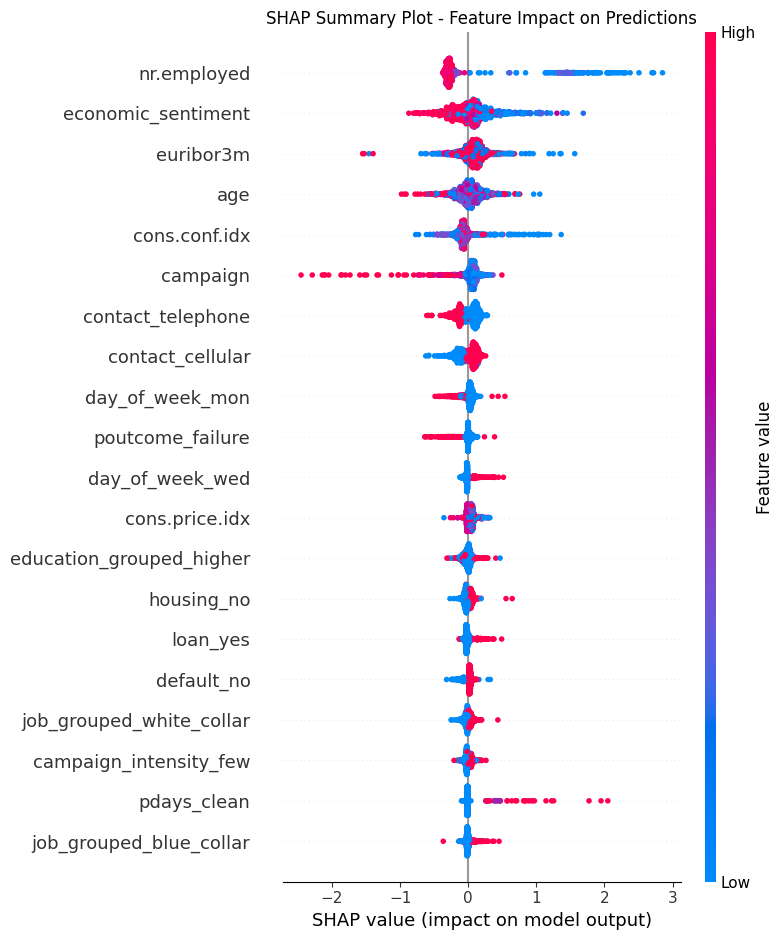


SHAP-based Feature Importance:
               feature  importance
9          nr.employed    0.424585
10  economic_sentiment    0.226244
8            euribor3m    0.157201
0                  age    0.139483
7        cons.conf.idx    0.133039
1             campaign    0.122160
37   contact_telephone    0.115821
36    contact_cellular    0.109440
49     day_of_week_mon    0.057841
53    poutcome_failure    0.046758


In [54]:
# Initialize SHAP explainer
if hasattr(best_model, 'predict_proba'):
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_val_processed[:1000])  # Use subset for speed
    
    # If binary classification, shap_values might be a list
    if isinstance(shap_values, list):
        shap_values_pos = shap_values[1]  # Positive class
    else:
        shap_values_pos = shap_values
    
    # Summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_pos, X_val_processed[:1000], 
                     feature_names=feature_names, show=False)
    plt.title('SHAP Summary Plot - Feature Impact on Predictions')
    plt.tight_layout()
    plt.show()
    
    # Feature importance from SHAP
    shap_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(shap_values_pos).mean(axis=0)
    }).sort_values('importance', ascending=False)
    
    print("\nSHAP-based Feature Importance:")
    print(shap_importance.head(10))

### SHAP Analysis Key Insights:

- Strongest Impact Features:

`nr.employed` shows the widest SHAP value range, confirming its dominance as the primary predictor  
`economic_sentiment` and euribor3m display significant bidirectional effects, indicating economic conditions strongly influence outcomes in both directions  
`age` shows moderate but consistent impact across the distribution  

- Directional Patterns: 

Economic indicators (`nr.employed`, `euribor3m`, `economic_sentiment`) show clear positive/negative splits - suggesting distinct economic conditions favor different outcomes
`Campaign` type shows mostly negative SHAP values (red dots on left), indicating certain campaign types consistently reduce success probability  
Contact methods (`contact_telephone`, `contact_cellular`) have opposing effects - one increases, one decreases success likelihood  

- Strategic Takeaways:  

1. Economic timing matters most - launch campaigns when employment and economic sentiment are favorable
2. Age targeting should be optimized based on the clear age-related patterns
3. Campaign type selection is crucial - current approach may be counterproductive
4. Contact method choice significantly impacts outcomes - telephone vs cellular preferences are evident

## 9. Error Analysis

In [55]:
# Get predictions on validation set
val_pred = best_model.predict(X_val_processed)
val_proba = best_model.predict_proba(X_val_processed)[:, 1]

# Find misclassified examples
false_positives = (val_pred == 1) & (y_val == 0)
false_negatives = (val_pred == 0) & (y_val == 1)

print(f"False Positives: {false_positives.sum()}")
print(f"False Negatives: {false_negatives.sum()}")

False Positives: 159
False Negatives: 530


In [56]:
# Analyze false positives
if false_positives.sum() > 0:
    fp_data = X_val[false_positives].copy()
    fp_data['predicted_proba'] = val_proba[false_positives]
    
    print("\n" + "="*50)
    print("FALSE POSITIVES ANALYSIS")
    print("="*50)
    print("Characteristics of clients wrongly predicted to subscribe:")
    
    for col in ['age', 'job_grouped', 'education_grouped', 'campaign', 'poutcome']:
        if col in fp_data.columns:
            print(f"\n{col} distribution in false positives:")
            if fp_data[col].dtype == 'object':
                print(fp_data[col].value_counts().head())
            else:
                print(fp_data[col].describe())

# Analyze false negatives
if false_negatives.sum() > 0:
    fn_data = X_val[false_negatives].copy()
    fn_data['predicted_proba'] = val_proba[false_negatives]
    
    print("\n" + "="*50)
    print("FALSE NEGATIVES ANALYSIS")
    print("="*50)
    print("Characteristics of clients wrongly predicted NOT to subscribe:")
    
    for col in ['age', 'job_grouped', 'education_grouped', 'campaign', 'poutcome']:
        if col in fn_data.columns:
            print(f"\n{col} distribution in false negatives:")
            if fn_data[col].dtype == 'object':
                print(fn_data[col].value_counts().head())
            else:
                print(fn_data[col].describe())




FALSE POSITIVES ANALYSIS
Characteristics of clients wrongly predicted to subscribe:

age distribution in false positives:
count    159.000000
mean      41.691824
std       16.389233
min       18.000000
25%       29.500000
50%       36.000000
75%       54.000000
max       88.000000
Name: age, dtype: float64

job_grouped distribution in false positives:
job_grouped
white_collar    75
retired         21
student         18
blue_collar     16
services        12
Name: count, dtype: int64

education_grouped distribution in false positives:
education_grouped
secondary    61
higher       54
basic        30
unknown      14
Name: count, dtype: int64

campaign distribution in false positives:
count    159.000000
mean       1.849057
std        1.126149
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        7.000000
Name: campaign, dtype: float64

poutcome distribution in false positives:
poutcome
nonexistent    80
success        47
failure        32
Name: count,

In [57]:
# Analyze prediction probabilities for misclassified examples
fp_probas = val_proba[false_positives]
fn_probas = val_proba[false_negatives]

print(f"False Positive probabilities - Mean: {fp_probas.mean():.3f}, Std: {fp_probas.std():.3f}")
print(f"False Negative probabilities - Mean: {fn_probas.mean():.3f}, Std: {fn_probas.std():.3f}")

False Positive probabilities - Mean: 0.715, Std: 0.142
False Negative probabilities - Mean: 0.161, Std: 0.144


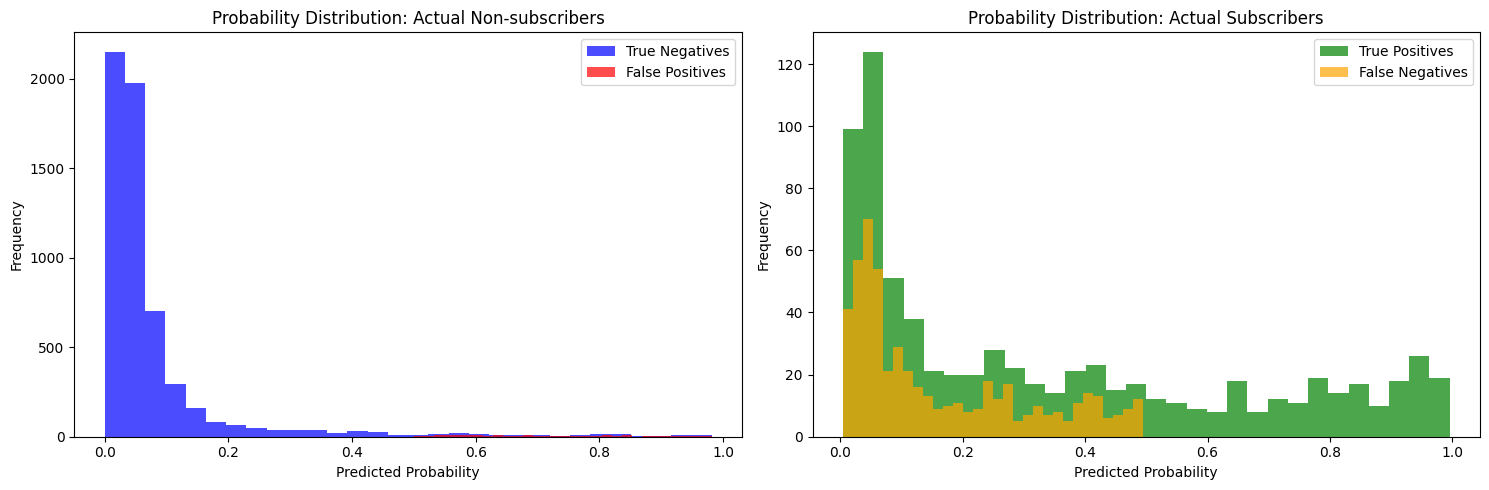

In [58]:
# Plot probability distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(val_proba[y_val == 0], bins=30, alpha=0.7, label='True Negatives', color='blue')
axes[0].hist(val_proba[false_positives], bins=30, alpha=0.7, label='False Positives', color='red')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Probability Distribution: Actual Non-subscribers')
axes[0].legend()

axes[1].hist(val_proba[y_val == 1], bins=30, alpha=0.7, label='True Positives', color='green')
axes[1].hist(val_proba[false_negatives], bins=30, alpha=0.7, label='False Negatives', color='orange')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Probability Distribution: Actual Subscribers')
axes[1].legend()

plt.tight_layout()
plt.show()

## 10. Improvement Recommendations

Based on the error analysis, here are recommendations to improve the model:

1. FEATURE ENGINEERING:
   - Create interaction features between economic indicators and demographic variables
   - Engineer time-based features (e.g., time since last economic crisis)
   - Create customer lifetime value features based on previous interactions
   - Develop risk profiling features combining multiple categorical variables

2. DATA COLLECTION:
   - Collect more granular timing information (time of day for calls)
   - Include external economic sentiment data
   - Add customer financial health indicators (if legally permissible)
   - Include competitor activity data

3. MODEL IMPROVEMENTS:
   - Try advanced ensemble methods (XGBoost, LightGBM, CatBoost)
   - Implement stacking/blending of multiple models
   - Use neural networks with embedding layers for categorical features
   - Try cost-sensitive learning to address class imbalance

4. THRESHOLD OPTIMIZATION:
   - Optimize prediction threshold based on business costs
   - Implement different thresholds for different customer segments
   - Use precision-recall curve analysis for threshold selection

5. HANDLING CLASS IMBALANCE:
   - Try SMOTE or other oversampling techniques
   - Implement undersampling of majority class
   - Use ensemble methods designed for imbalanced data
   - Apply different class weights in model training

6. BUSINESS LOGIC INTEGRATION:
   - Incorporate business rules (e.g., don't call customers who recently subscribed)
   - Add customer fatigue models (reduce probability after multiple calls)
   - Implement seasonal adjustment factors

7. MODEL VALIDATION:
   - Use time-based cross-validation if data has temporal structure
   - Implement A/B testing framework for model deployment
   - Add model drift detection and retraining pipelines

8. INTERPRETATION & EXPLAINABILITY:
   - Develop customer-specific explanation reports
   - Create simplified decision trees for business users
   - Implement LIME for local explanations


## 11. Final Model Evaluation on Test Set

In [59]:
X_test_processed = preprocessor.transform(X_test)
test_pred = best_model.predict(X_test_processed)
test_proba = best_model.predict_proba(X_test_processed)[:, 1]

In [60]:
# Calculate all metrics
test_metrics = {
    'Accuracy': accuracy_score(y_test, test_pred),
    'Precision': precision_score(y_test, test_pred),
    'Recall': recall_score(y_test, test_pred),
    'F1-Score': f1_score(y_test, test_pred),
    'ROC-AUC': roc_auc_score(y_test, test_proba)
}

print(f"Best Model: {best_model_name}")
print("-" * 30)
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

Best Model: GB_Random_OS
------------------------------
Accuracy: 0.8996
Precision: 0.6091
Recall: 0.3039
F1-Score: 0.4055
ROC-AUC: 0.7832


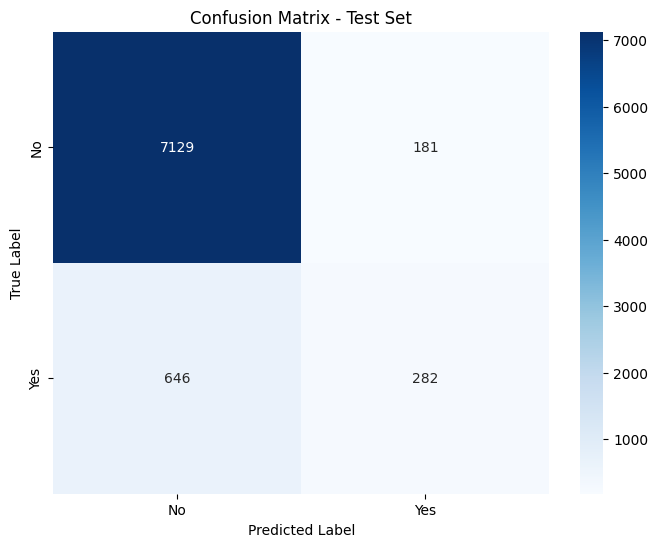

In [61]:
# Confusion matrix
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [62]:
print("Detailed Classification Report:")
print(classification_report(y_test, test_pred, target_names=['No', 'Yes']))

Detailed Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.98      0.95      7310
         Yes       0.61      0.30      0.41       928

    accuracy                           0.90      8238
   macro avg       0.76      0.64      0.68      8238
weighted avg       0.88      0.90      0.88      8238



## 12. Business Impact Analysis

In [63]:
# Calculate business metrics
total_customers = len(y_test)
actual_subscribers = y_test.sum()
predicted_subscribers = test_pred.sum()
true_positives = ((test_pred == 1) & (y_test == 1)).sum()
false_positives = ((test_pred == 1) & (y_test == 0)).sum()

# Assume some business values (these would come from domain experts)
cost_per_call = 5  # Cost to make a marketing call
revenue_per_subscription = 200  # Revenue from each subscription
marketing_budget = total_customers * cost_per_call

# Business metrics
precision_rate = true_positives / predicted_subscribers if predicted_subscribers > 0 else 0
recall_rate = true_positives / actual_subscribers if actual_subscribers > 0 else 0

# Financial impact
current_revenue = true_positives * revenue_per_subscription
current_cost = predicted_subscribers * cost_per_call
current_profit = current_revenue - current_cost

# Baseline (call everyone)
baseline_revenue = actual_subscribers * revenue_per_subscription
baseline_cost = total_customers * cost_per_call
baseline_profit = baseline_revenue - baseline_cost

print(f"Model Performance:")
print(f"  - Customers to call: {predicted_subscribers} ({predicted_subscribers/total_customers*100:.1f}% of total)")
print(f"  - Expected subscriptions: {true_positives} ({precision_rate*100:.1f}% success rate)")
print(f"  - Subscriptions captured: {recall_rate*100:.1f}% of all potential subscribers")

print(f"\nFinancial Impact:")
print(f"  - Model profit: ${current_profit:,.2f}")
print(f"  - Baseline profit (call everyone): ${baseline_profit:,.2f}")
print(f"  - Profit improvement: ${current_profit - baseline_profit:,.2f}")
print(f"  - Cost reduction: ${baseline_cost - current_cost:,.2f} ({(baseline_cost - current_cost)/baseline_cost*100:.1f}%)")


Model Performance:
  - Customers to call: 463 (5.6% of total)
  - Expected subscriptions: 282 (60.9% success rate)
  - Subscriptions captured: 30.4% of all potential subscribers

Financial Impact:
  - Model profit: $54,085.00
  - Baseline profit (call everyone): $144,410.00
  - Profit improvement: $-90,325.00
  - Cost reduction: $38,875.00 (94.4%)


## 13. Final Results Summary

In [69]:
results_df.drop(columns=['Hyperparameters','Comment'], inplace=True)
print("Model Comparison Table:")
results_df

Model Comparison Table:


,Model,Train_F1,Val_F1,Val_Recall,Train_AUC,Val_AUC
0,LR_Original,0.4480,0.4490,0.6321,0.7940,0.7980
1,LR_SMOTE,0.7067,0.4493,0.6361,0.8003,0.7943
2,LR_Random_OS,0.7056,0.4511,0.6307,0.7923,0.7975
3,LR_ADASYN,0.6485,0.4011,0.6712,0.7459,0.7898
4,kNN_Original,0.4510,0.3373,0.2493,0.9221,0.7146
5,kNN_SMOTE,0.8792,0.3539,0.6146,0.9540,0.7472
6,kNN_Random_OS,0.8233,0.3459,0.6873,0.9118,0.7496
7,kNN_ADASYN,0.8695,0.3364,0.6429,0.9434,0.7376
8,DT_Original,0.4823,0.4215,0.5916,0.8494,0.7442
9,DT_SMOTE,0.8192,0.4651,0.4811,0.9023,0.7400


In [70]:
print(f" BEST PERFORMING MODEL: {best_model_name}")

print(f" Test Set F1-Score: {test_metrics['F1-Score']:.4f}")
print(f" Test Set ROC-AUC: {test_metrics['ROC-AUC']:.4f}")

 BEST PERFORMING MODEL: GB_Random_OS
 Test Set F1-Score: 0.4055
 Test Set ROC-AUC: 0.7832
